In [6]:
from fbm import fbm
from SBTS import *
from metrics import *
from tools import *

**Definition.** The fractional Brownian motion $(W_t^H)_{t \in [0,T]}$ is a centered Gaussian process starting from zero, with covariance function
$$\mathbb{E}\left[ W_t^H W_s^H \right] = \frac{1}{2} \left(|t|^{2H} + |s|^{2H} - |t - s|^{2H} \right),$$
where $H \in (0,1)$ is the Hurst index. Note that when $H = 0.5$, fractional Brownian motion coincides with standard Brownian motion (the Wiener process).

Unlike standard Brownian motion, the increments of fractional Brownian motion are not independent. When $H < 0.5$, they are negatively correlated (the anti-persistence phenomenon), whereas for $H > 0.5$, they are positively correlated (the persistence phenomenon). This behavior is directly observable in plots below.

Moreover, fractional Brownian motion is $(H - \varepsilon)$-Hölder continuous for any $\varepsilon > 0$. Consequently, the smaller the Hurst index $H$, the less regular the sample paths are, and the rougher the process.


Several methods can be used to simulate fractional Brownian motion; however, detailing them is beyond the scope of this project. In practice, we exploit the fact that $W^H$ is a Gaussian process and rely on a Cholesky decomposition. We use the Python package `fbm` with `method="cholesky"`.

### Displaying trajectories via `fbm`

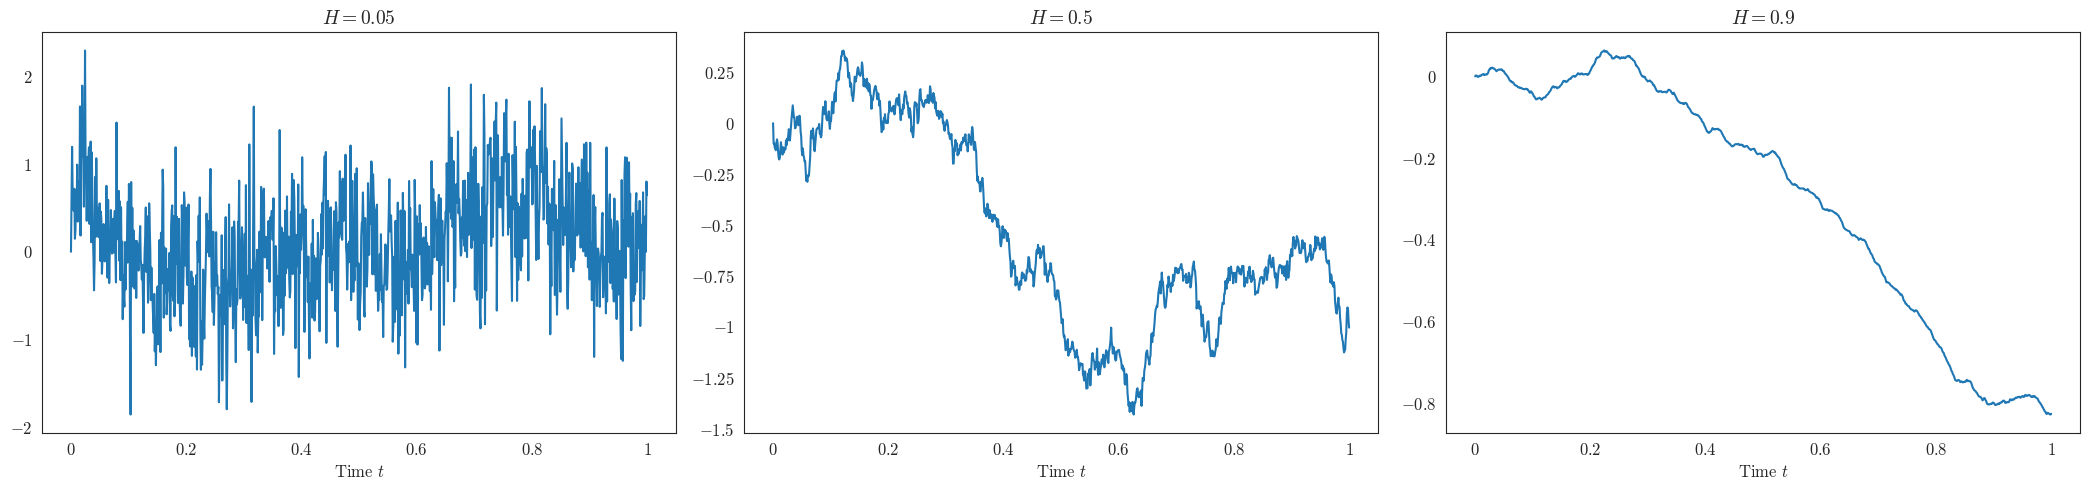

In [15]:
n = 1024
T = 1 
t_values = np.linspace(0, T, n+1) 

fig, ax = plt.subplots(1, 3, figsize=(21,5))
ax[0].plot(t_values, fbm(n, hurst = 0.05,length = T, method = "cholesky"))
ax[0].set_title(fr"$H = 0.05$", fontsize=14)

ax[1].plot(t_values, fbm(n, hurst = 0.5, length = T, method = "cholesky"))
ax[1].set_title(fr"$H = 0.5$", fontsize=14)

ax[2].plot(t_values, fbm(n, hurst = 0.9, length = T, method = "cholesky"))
ax[2].set_title(fr"$H = 0.9$", fontsize=14)

for i in range(3) : 
    ax[i].set_xlabel(r"$\text{Time }t$", fontsize=12)
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")

plt.tight_layout()
plt.show()

### Generation of synthetic trajectories 

We now turn to the generation of trajectories resembling such processes.
The time grid is defined as $t_k = kT/N$, with $k = 0, \ldots, N$, $T = 1$, and $N = 252$, corresponding to daily observations over one year. We further use $M = 1000$ reference trajectories.



As mentioned in the related papers, the process involved in SBTS must be stationary. To this end, we work with increments, namely
$$(\widetilde{X}_{t_0}, \ldots, \widetilde{X}_{t_N})
:=
\left(
0,\,
W_{t_1}^H,\,
W_{t_2}^H - W_{t_1}^H,\,
\ldots,\,
W_{t_N}^H - W_{t_{N-1}}^H
\right).$$

Moreover, the parameters $(h, r)$ are not invariant with respect to the Hurst index $H$. In particular, $r = 1$ is appropriate for standard Brownian motion, as this process is Markovian. By contrast, the bandwidth parameter $h$ (which implicitly depends on $r$) must be adjusted according to the value of $H$.
Table below summarizes the parameters used for each Hurst index.

|          | $H = 0.2$ | $H = 0.5$ | $H = 0.8$ |
|----------|-----------|-----------|-----------|
| $h$      | $0.02$    | $0.5$     | $0.05$    |
| $r$      | $7$       | $1$       | $30$      |
| $N^\pi$  | $200$     | $100$     | $100$     |

#### $H = 0.5$

In [23]:
h = 0.5
N_pi = 100
r = 1

In [25]:
M = 1000
N = 252
T = N/252 
delta = T/N 
H = 0.5
X = np.array([fbm(N, hurst = H, length = T, method = "cholesky") for _ in range(M)])
X_incr = np.diff(X, axis=1)  
std = X_incr.std()
X_incr = X_incr * np.sqrt(delta) / std
X_incr_zero = np.hstack([np.zeros((M, 1)), X_incr])

In [35]:
vals = simulate_SBTS_trajectories(X_incr_zero, 1000, h, delta, N_pi, x0 = 0.0, markov_proj = True, r=r)

100%|███████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


In [37]:
vals = vals * std / np.sqrt(delta) 
dY = vals[:, 1:]                           
vals_05 = np.c_[np.zeros((vals.shape[0], 1)), np.cumsum(dY, axis=1)] 
X_05 = X 

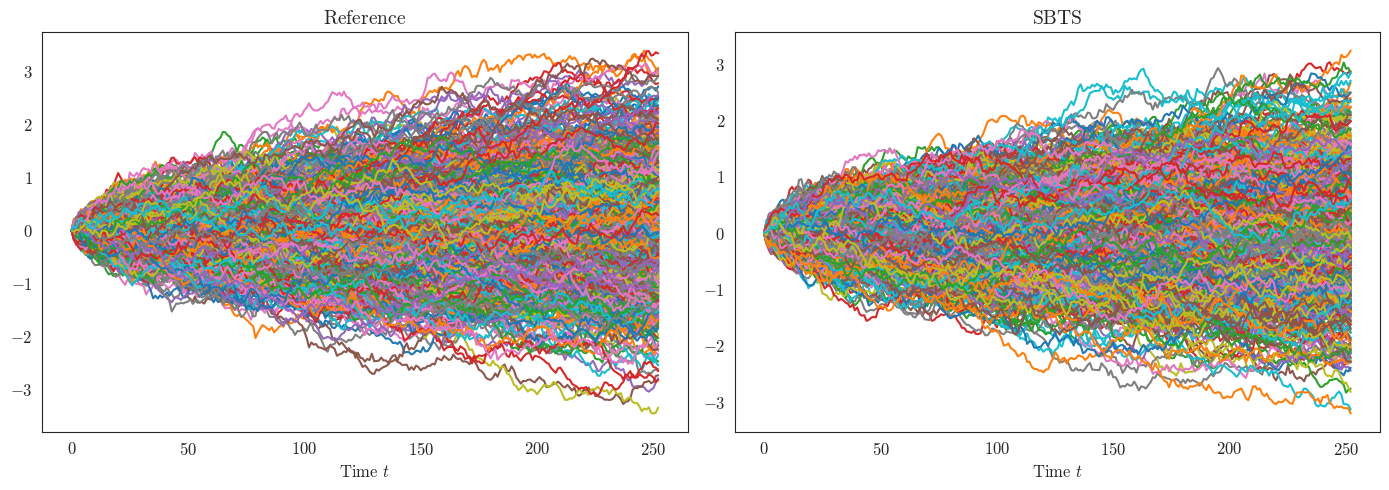

In [39]:
plot_traj_12(X_05, vals_05)

In [113]:
discriminative_scores, predictive_scores = scores(X_05, vals_05, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = False)

100%|██████████████████████████████████████████| 10/10 [32:29<00:00, 195.00s/it]

Discriminative score : 0.019 +- 0.013
Predictive score : 0.0 +- 0.0


#### $H = 0.8$. 

In [42]:
h = 0.05 
N_pi = 100
r = 30 

In [44]:
M = 1000
N = 252
T = N/252 
delta = T/N 
H = 0.8
X = np.array([fbm(N, hurst = H, length = T, method = "cholesky") for _ in range(M)])
X_incr = np.diff(X, axis=1)  
std = X_incr.std()
X_incr = X_incr * np.sqrt(delta) / std
X_incr_zero = np.hstack([np.zeros((M, 1)), X_incr])

In [46]:
vals = simulate_SBTS_trajectories(X_incr_zero, 1000, h, delta, N_pi, x0 = 0.0, markov_proj = True, r=r)

100%|███████████████████████████████████████| 1000/1000 [05:44<00:00,  2.91it/s]


In [48]:
vals = vals * std / np.sqrt(delta) 
dY = vals[:, 1:]                           
vals_08 = np.c_[np.zeros((vals.shape[0], 1)), np.cumsum(dY, axis=1)] 
X_08 = X 

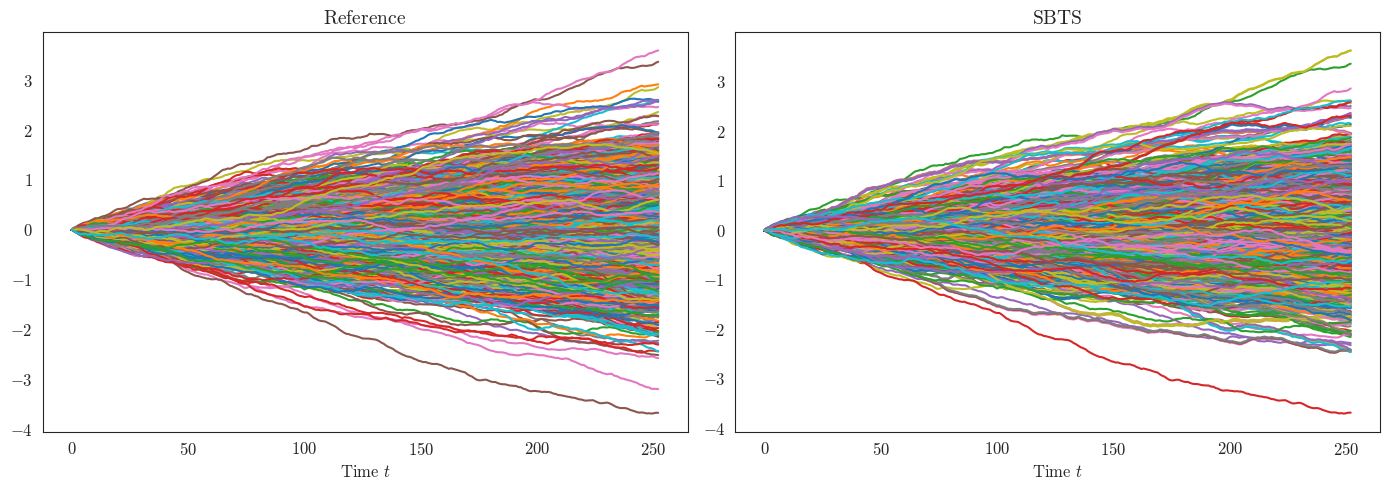

In [50]:
plot_traj_12(X_08, vals_08)

In [119]:
discriminative_scores, predictive_scores = scores(X_08, vals_08, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = False)

100%|██████████████████████████████████████████| 10/10 [28:30<00:00, 171.02s/it]

Discriminative score : 0.017 +- 0.014
Predictive score : 0.0 +- 0.0


#### $H = 0.2$. 

In [53]:
h = 0.02
N_pi = 200
r = 7 

In [55]:
M = 1000
N = 252
T = N/252 
delta = T/N 
H = 0.2
X = np.array([fbm(N, hurst = H, length = T, method = "cholesky") for _ in range(M)])
X_incr = np.diff(X, axis=1)  
std = X_incr.std()
X_incr = X_incr * np.sqrt(delta) / std
X_incr_zero = np.hstack([np.zeros((M, 1)), X_incr])

In [65]:
vals = simulate_SBTS_trajectories(X_incr_zero, 1000, h, delta, N_pi, x0 = 0.0, markov_proj = True, r=r)

100%|███████████████████████████████████████| 1000/1000 [11:34<00:00,  1.44it/s]


In [67]:
vals = vals * std / np.sqrt(delta) 
dY = vals[:, 1:]                           
vals_02 = np.c_[np.zeros((vals.shape[0], 1)), np.cumsum(dY, axis=1)] 

In [69]:
X_02 = X 

In [79]:
mask = np.any(np.abs(vals_02) < 10, axis=1)
vals_02_filtered = vals_02[mask]
vals_02_filtered = vals_02[np.all(np.abs(vals_02) <= 15, axis=1)]
vals_02_filtered.shape

(998, 253)

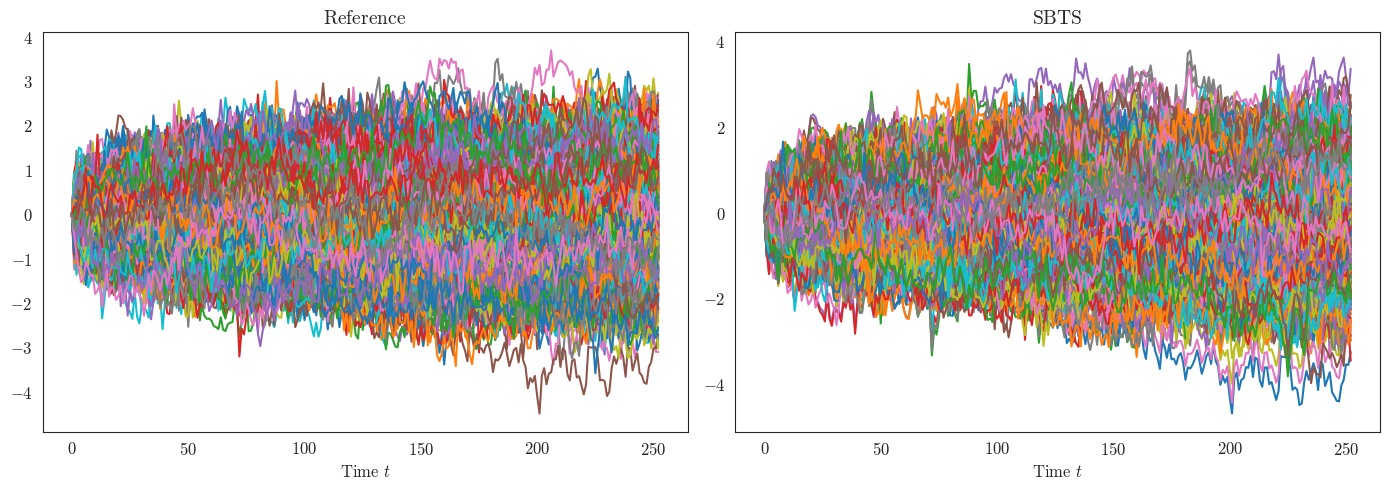

In [77]:
plot_traj_12(X_02, vals_02_filtered)

In [125]:
discriminative_scores, predictive_scores = scores(X_02, vals_02_filtered, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = False)

100%|██████████████████████████████████████████| 10/10 [28:57<00:00, 173.72s/it]

Discriminative score : 0.03 +- 0.021
Predictive score : 0.0 +- 0.0


### Estimation of the Hurst index 

From the definition above, it follows immediately that
$$\mathbb{E}\left[\left| W_t^H - W_s^H \right|^2 \right] = |t - s|^{2H}.$$
By the ergodic theorem, we have the almost sure convergence
$$\frac{1}{N^{1 - 2H}}
\sum_{i=0}^{N-1}
\left| W_{\frac{i+1}{N}}^H - W_{\frac{i}{N}}^H \right|^2
\xrightarrow[N \to +\infty]{\text{a.s.}}
1.$$

Now suppose that we observe a time series $(0 = X_{t_0}, X_{t_1}, \ldots, X_{t_N})$, with $t_i = iT/N$, $i = 0, \ldots, N$.
It is then natural to introduce the following estimator for the Hurst index:
$$\widehat H:= \frac 12 \left(1-\frac{\ln\left(\sum_{i=0}^{N-1}\left|X_{t_{i+1}} - X_{t_i}\right|^2\right)}{\ln(N)}\right).$$

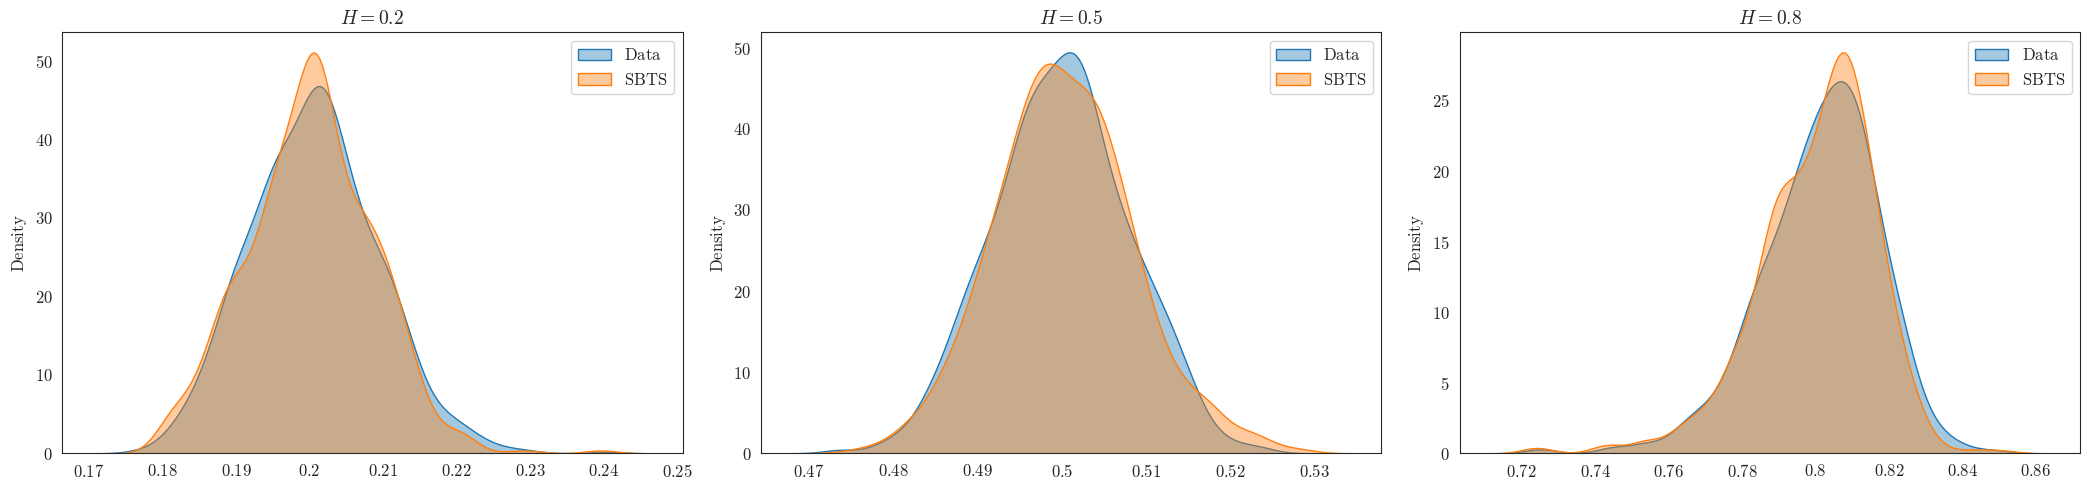

In [127]:
plot_estimation_H(X_02, vals_02_filtered, X_05, vals_05, X_08, vals_08)

### Quadratic variation, Kolmogorov-Smirnov test and covariance matrix 

#### $H = 0.2$

In [141]:
quadratic_var_X_02 = np.power(np.diff(X_02), 2).sum(axis = 1)
quadratic_var_SBTS_02 = np.power(np.diff(vals_02_filtered), 2).sum(axis = 1)

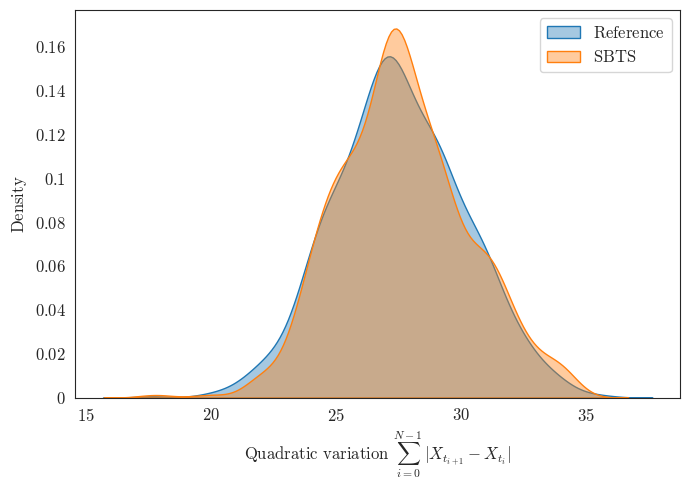

In [143]:
plot_quadratic_variation(quadratic_var_X_02, quadratic_var_SBTS_02)

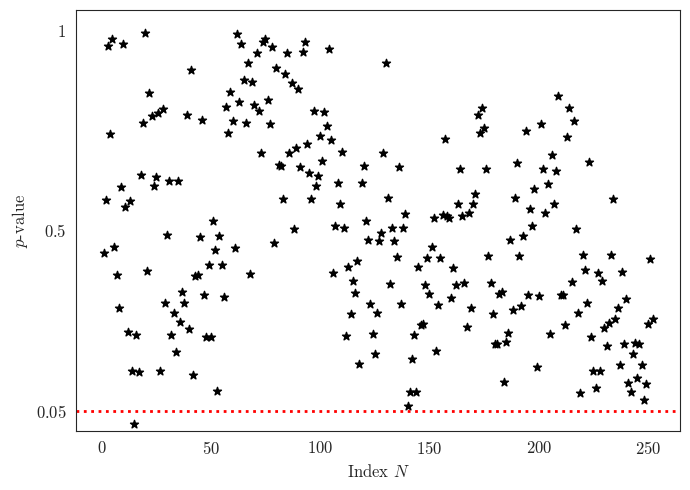

In [160]:
plot_pvalues_KS(X_02, vals_02_filtered, N)

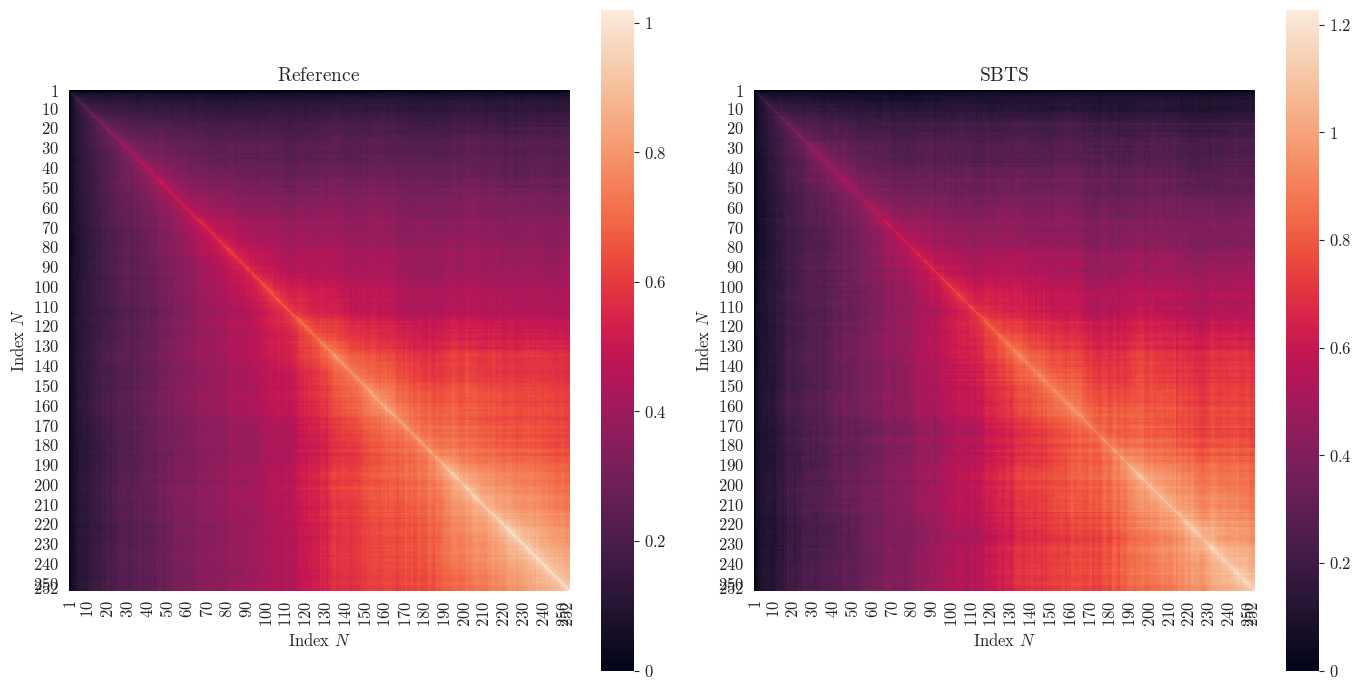

In [177]:
plot_correlation_matrix(X_02, vals_02_filtered, N)

#### $H = 0.5$

In [151]:
quadratic_var_X_05 = np.power(np.diff(X_05), 2).sum(axis = 1)
quadratic_var_SBTS_05 = np.power(np.diff(vals_05), 2).sum(axis = 1)

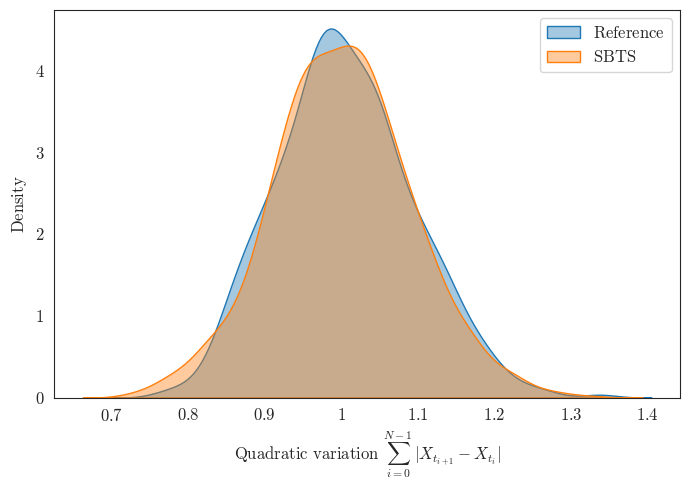

In [155]:
plot_quadratic_variation(quadratic_var_X_05, quadratic_var_SBTS_05)

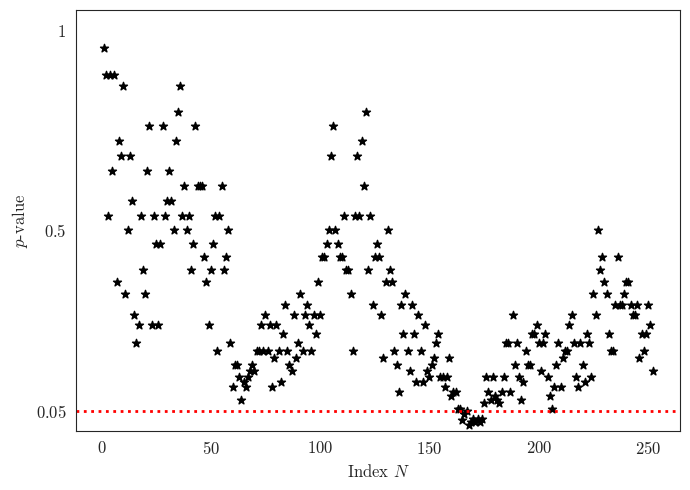

In [162]:
plot_pvalues_KS(X_05, vals_05, N)

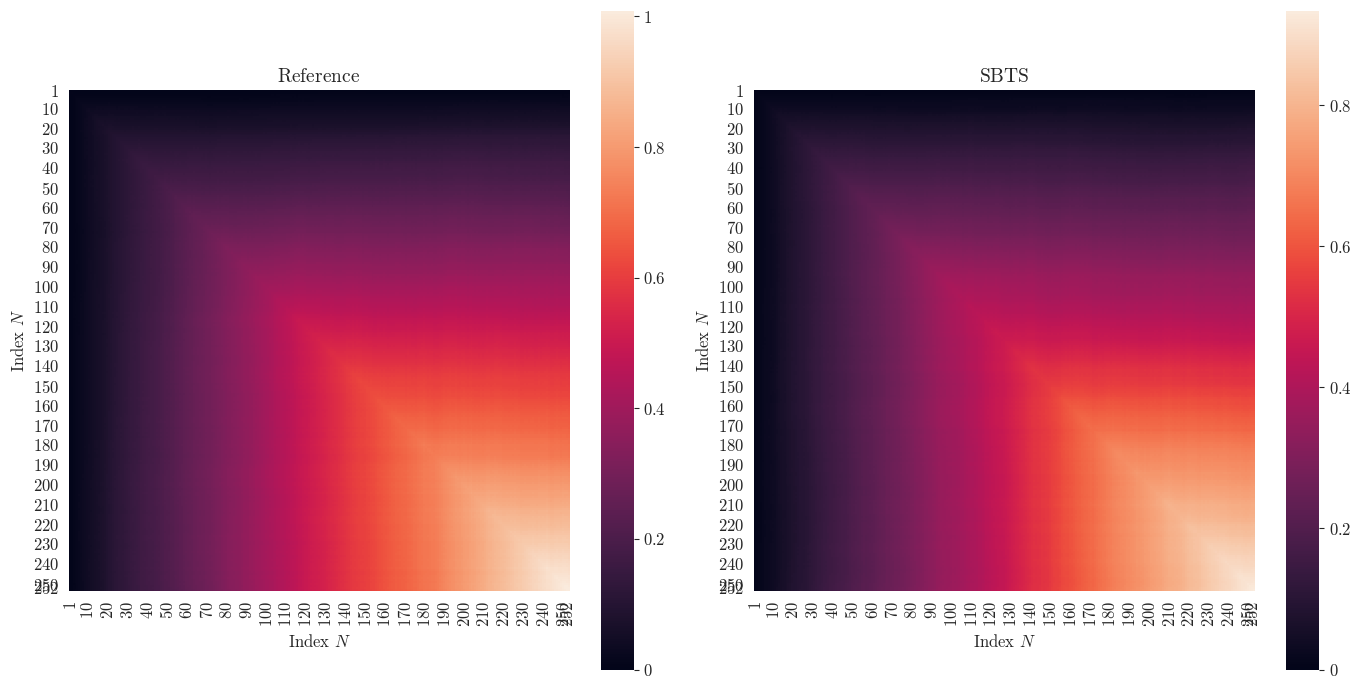

In [179]:
plot_correlation_matrix(X_05, vals_05, N)

#### $H = 0.8$

In [153]:
quadratic_var_X_08 = np.power(np.diff(X_08), 2).sum(axis = 1)
quadratic_var_SBTS_08 = np.power(np.diff(vals_08), 2).sum(axis = 1)

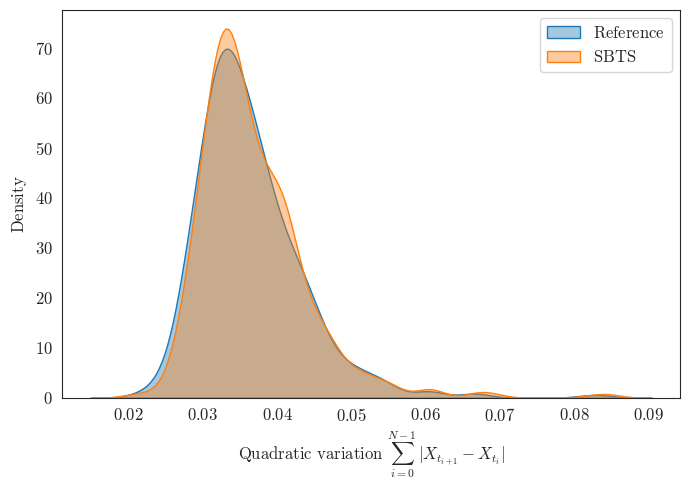

In [157]:
plot_quadratic_variation(quadratic_var_X_08, quadratic_var_SBTS_08)

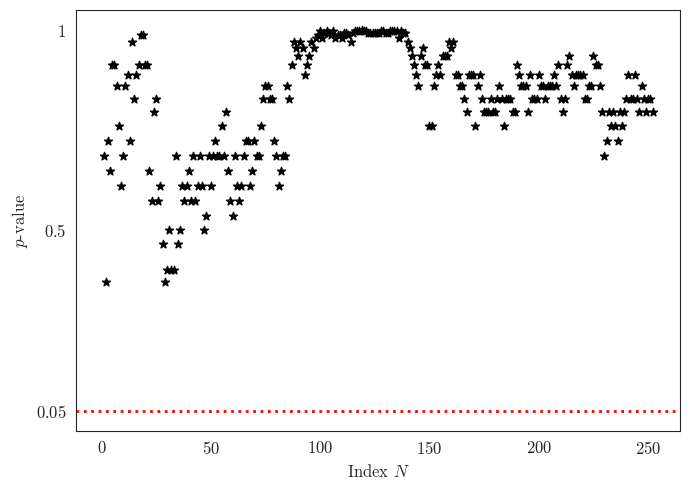

In [164]:
plot_pvalues_KS(X_08, vals_08, N)

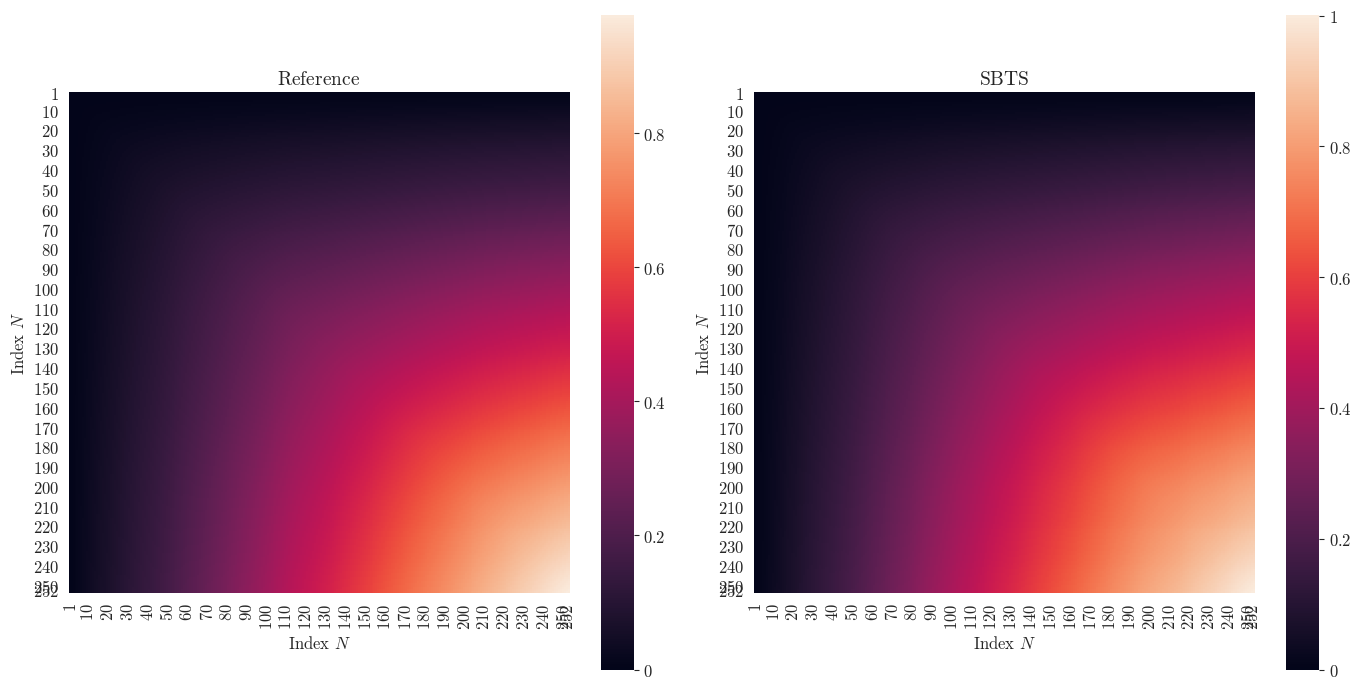

In [181]:
plot_correlation_matrix(X_08, vals_08, N)

### Join marginal distribution 

In [191]:
df_data_SBTS = pd.DataFrame()
df_data_SBTS["X_{t_1}"] = X_05[:,1].tolist() + vals_05[:,1].tolist()
df_data_SBTS["X_{t_{N}}"] = X_05[:,-1].tolist() + vals_05[:,-1].tolist()
df_data_SBTS["type"] = [r"$\text{Reference}$"]*1000 + [r"$\text{SBTS}$"]*1000

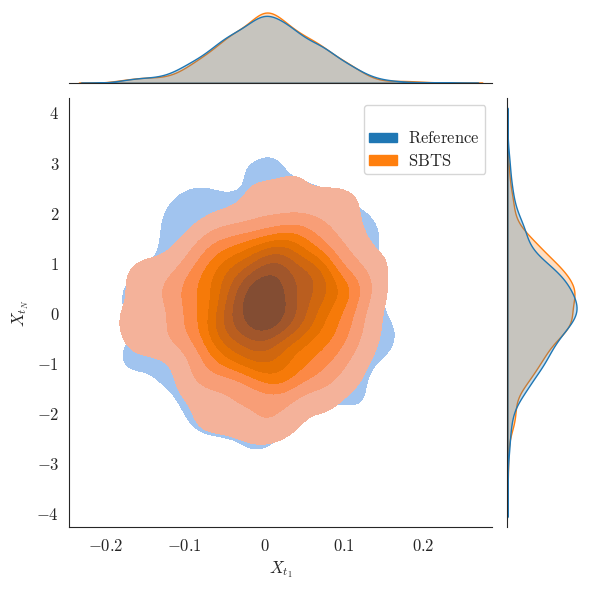

In [193]:
x = "X_{t_1}" 
y = "X_{t_{N}}"
plot_join_marginal_distribution(df_data_SBTS, x, y)